In [1]:
# read the tiny-shakespere.txt dataset
with open('tiny-shakespere.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
print('length of dataset in chars: ', len(text))

length of dataset in chars:  1115394


In [3]:
# look at the 1st 1000 chars
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [4]:
# create vocab by looking at all the unique chars
chars = sorted(
    # ordered array, based on some random ordering
    list(
        # creat a set of unique chars in dataset
        set(text)
    )
)
# vocab size is char size
vocab_size = len(chars)
# print all the vocab
print('\n---- vocab -----\n', ''.join(chars))
print('\n---- vocab size -----\n', vocab_size)


---- vocab -----
 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

---- vocab size -----
 65


## Tokenization
create tokens from vocabs
- in our case, 1 char -> 1 integer

we will use simple mapping for us, integers from [0, 64] for each char.

more complex tokenization like [byte pair encoding](https://huggingface.co/learn/nlp-course/en/chapter6/5) uses different encoding at subword level.

Bytecode pair encoding is used in practice for GPT

it is a tradeoff
- small vocab (like ours 65) -> long encoding size
- large vocab (50k) -> short encoding size

In [5]:
# create tokens based on simple mapping dict

# string to int map
stoi = { ch:i for i, ch in enumerate(chars) }

# int to string map
itos = { i:ch for i, ch in enumerate(chars) }

# encoder: take string s, output array of int
encode = lambda s: [ stoi[c] for c in s ]

# decoder: take list of int, output string
decode = lambda l: ''.join([ itos[i] for i in l ])

In [6]:
# encode the sentence, notice the encoded size is same size as input
print(encode('hii there'))
print(decode(encode('hii there')))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
# now tokenize the entire dataset of shakespere
# we will wrapped the encoded tokens as a pyTorch tensor
import torch

data = torch.tensor( encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # first 1k tokens

/Users/yoshichen/miniconda3/envs/nlp-learning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [8]:
# do train/validation split, 90/10
n = int(0.9 * len(data)) # first 90% will be used for training
train_data = data[:n]
val_data = data[n:]

We are now ready to feed the data into a transformer to train.

We need to split the data into chunks, because we cant always fit the entire dataset in memory.

We will train on randomly selected chunks of data.  The chunk size is a **block**, or _context_size_, or _block_size_.

In [9]:
# define block size
block_size = 8
train_data[:block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

the goal of the model is to predicting the next char.

notice that for the training block above, we can extract 8 training samples:
- input [18], next char [47]
- input [18, 47], next char [56]
- input [18, 47, 56], next chart [57]
- ...

because we are training input size is _block_size_, or **context size**
- the transformer will never see data more than _block_size_ (or context)
- the transformer knows how to gnereate next char
    - if user input is size is from 1 - _block_size_
    - transform doesnt know how to generate data if input is > _block_size_ (context)

In [10]:
# print out the 8 training samples

# the input
x = train_data[:block_size]
# next char, shifted 1 
y = train_data[1:block_size + 1]

# for the block size
for t in range(block_size):
    # get the previous chars
    context = x[:t+1]
    # following next char
    target = y[t]
    print(f'when input is {context}, target: {target}')

when input is tensor([18]), target: 47
when input is tensor([18, 47]), target: 56
when input is tensor([18, 47, 56]), target: 57
when input is tensor([18, 47, 56, 57]), target: 58
when input is tensor([18, 47, 56, 57, 58]), target: 1
when input is tensor([18, 47, 56, 57, 58,  1]), target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]), target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]), target: 58


Now we need to introduce the concept of **batching**, for efficiency reasons, to keep GPU busy.

Each _randomly sampled_ batch of _block_size_ is processed independenty in parallel

In [11]:
# create seed for randomness
torch.manual_seed(1337)
batch_size = 4 # how many independent sequence processed in parallel?
block_size = 8 # max context size used to predict next char

def get_batch(split):
    '''
    get random batches of `batch_size` from train/validation data

    args:
        split: `train` or `val` data
    '''
    # use `train` dataset if split is `train`
    data = train_data if split == 'train' else val_data

    # get 4 batch of random indices
    ix = torch.randint(
        len(data) - block_size, # rand range [0, data_size - block_size]
        (batch_size, ) # shape: [batch_size, 1]
    )
    # stack 4 batches of 8 tokens into [4, 8] matrix
    # this is the context matrix
    x = torch.stack(
        [
            data[i:i+block_size] for i in ix
        ]
    )
    # stack 4 batches of `target` chars,
    # which is just 1 shifted over, since we are predicting next char
    y = torch.stack(
        [
            data[i+1 : i+block_size+1] for i in ix
        ]
    )
    return x, y

In [12]:
xb, yb = get_batch('train')
print('inputs')
print(xb.shape)
print(xb)
print()
print('targets')
print(yb.shape)
print(yb)

inputs
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])

targets
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [13]:
# pretty print of each `context` and `target`
print('-----')

for b in range(batch_size): # batch dimension
    print(f'\n----- batch {b} -----\n')
    for t in range(block_size): # time dimension
        context = xb[b, :t+1] # batch b, [0, t]
        target = yb[b, t] # batch b, t_th token
        print(f'when input is {context.tolist()}, the target is {target}')

-----

----- batch 0 -----

when input is [24], the target is 43
when input is [24, 43], the target is 58
when input is [24, 43, 58], the target is 5
when input is [24, 43, 58, 5], the target is 57
when input is [24, 43, 58, 5, 57], the target is 1
when input is [24, 43, 58, 5, 57, 1], the target is 46
when input is [24, 43, 58, 5, 57, 1, 46], the target is 43
when input is [24, 43, 58, 5, 57, 1, 46, 43], the target is 39

----- batch 1 -----

when input is [44], the target is 53
when input is [44, 53], the target is 56
when input is [44, 53, 56], the target is 1
when input is [44, 53, 56, 1], the target is 58
when input is [44, 53, 56, 1, 58], the target is 46
when input is [44, 53, 56, 1, 58, 46], the target is 39
when input is [44, 53, 56, 1, 58, 46, 39], the target is 58
when input is [44, 53, 56, 1, 58, 46, 39, 58], the target is 1

----- batch 2 -----

when input is [52], the target is 58
when input is [52, 58], the target is 1
when input is [52, 58, 1], the target is 58
when inp

In [14]:
# create the simplest NN language model, the bigram model
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

# Bigram Model (Embedding from bigram)

In [44]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        
        # each token directly reads of logit for the next token from lookup table
        # nn.Embedding is a thin wrappr of tensor size [vocab_size, vocab_size]
        # or square matrix.
        # the weights/values for each Embedding dimension will be `learned`.
        # the learned values can be interpret as the probability of a char following the prev
        # 
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # B = batch size
        # T = time dimension (each batch has blockSize/context size=8 words)
        # C=channel=vocab size (1 hot encoding?)
        
        # idx and targets are both [batch, time] tensor of int
        # idx = inputs of size [batch, time], same as `xb` above
        # target = targe of size [batch, time], same as `yb` above 
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else: 
            B, T, C = logits.shape
            # we need to change the shape of the logits to match pytorch's cross_entropy method
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss


    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current vocab
        for _ in range(max_new_tokens):
            # get the predictions, notice we dont pass in targets, loss=None in this case
            # prediction shape (B, T, C)
            logits, loss = self(idx)
            # look at the last timestep only
            logits = logits[:, -1, :] # becoms (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B,C)
            # sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to running sequence
            '''
            notice that we pass in the entire idx to the next `generate` call
            - this doesnt makes sense cuz it s a bigram model, which only looks at the prev char (hist size=1)
            - but this method is written in a generic manner, so we can expand to look back at longer history
            '''
            idx = torch.cat( (idx, idx_next), dim=1) # (B, T+1)

        return idx

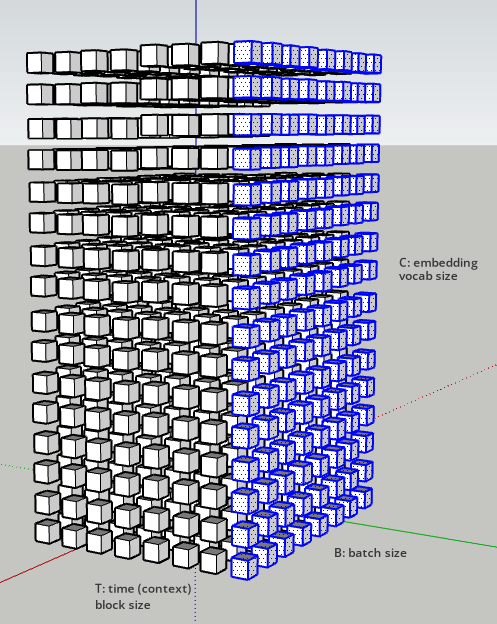

`generate()`: given the previes _idx_ (non-blue), predict the next time slice (blue)

the `BigramLanguageModel` initialize embedding of _[vocab_size, vocab_size]_.

a forward pass of 1 batch

In [23]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.9095, grad_fn=<NllLossBackward0>)


In [26]:
# logits is probability of next character
# we have 65 char, assume equal likely, the probability is
print(1.0/65)

import numpy as np
# we expect the baseline (the model doesnt know anything) loss for  negative log likelihood is
print(-np.log(1.0/65))

0.015384615384615385
4.174387269895637


In [27]:
# 4.17 < 4.9, which means our prediction is not completely random, due to possibly initial noise

In [36]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

# 1x1 tensor of 0, which is the char '.', to start generate
idx = torch.zeros( (1,1), dtype=torch.long)
print(
    decode(
        # generate 100 tokens, start with '.', (B=1,T=1), 1 batch of 1 char='.'
        # returns (1, 101)
        m.generate(idx, max_new_tokens=100)[0].tolist()
    )
)

torch.Size([32, 65])
tensor(4.4399, grad_fn=<NllLossBackward0>)

aEnF-G-3Nysg;Fr
3O$smz!R!b:AC$P;vXaDuhnn:wqL3hZR$x b-IgpYb,EIKcOro?MdOUmzHvM?FVEuTkk;iiB$a'.pzMBaVC.


In [46]:
# we see random garbage generated because the model is not trained
# lets train now

# create pytorch optimizer
# remember in `makemore` we use only stochostic gradient descent (SGD)
# here we will use ADAM, typical typical learning rate is 1e-4
# for small network like this we can use higher 1e-3
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [51]:
# repeat until we have converging loss
batch_size = 32
for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # forward pass, evaluate the loss
    logits, loss = m(xb, yb)
    # reset all the gradients
    optimizer.zero_grad(set_to_none=True)
    # backward pass
    loss.backward()
    # update
    optimizer.step()

print(loss.item())
    

2.6583077907562256


In [54]:
# now sample from the trained bigram model (embedding)
idx = torch.zeros( (1,1), dtype=torch.long)
print(
    decode(
        # generate 100 tokens, start with '.', (B=1,T=1), 1 batch of 1 char='.'
        # returns (1, 101)
        m.generate(idx, max_new_tokens=500)[0].tolist()
    )
)


AREOLLA sur inst, meatomyo nord I t adstof higoe! woue thy myom k'secthanind!'Purg mese?
Vowindssind stlostthou halverenozakierasheforcharoud iery t blleayoundors
He wony we'd, lyorfimigt thedsg un
Shouns whunklll lounoklpou d:
Bungute igost m pords
VIshad tan. hef nomathoucaild
Ane:

IELANTI marano RI'll ss h'da INThomor heile IOrte prof s yshe un w:
h OUTo d


Ingay ckeyout uay ad ton wander sthere han.
N: f beedsicl inare kn?
NGAnd, beamisow, t nthar:
Matthanod rid p g f inge!
Bupales fard t 


# The mathematical trick in self attention
we have 8 tokens, each has 2 channels of info, and there are 4 independent batches of tokens.

### example 
given 1st 5 tokens, predict the 6th token
- we need to look at the 5 tokens, gather info/features in some way
  - one lossy way to do this is just to avg all the token channels, up to the 5th token
  - it s lossy because we dont take into account of sequencing/positioning info, and other possible features
 
- we **cannot** look at data at 6th to 8th tokens, because those are future tokens, we are trying to predict the future

In [67]:
# consider the following toy example
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

### version 1

In [68]:
# we want x[b,t] = mean_{i<=t} x[b,i]
# _bow is short for 'bag of words'
# a term for 'avg a bunch of words', since a bag of stuff doesnt care bout position info
xbow = torch.zeros( (B,T,C) )
for b in range(B):
    for t in range(T):
        # slice the data
        # at this batch, take the [0,t] tokens inclusive, so we have 't' tokens
        # each token has C channel, so the slice is shape (t,C)
        xprev = x[b,:t+1] # (t,C)
        # avg all tokens, so avg on dim 0, we have shape (1,C)
        xbow[b,t] = torch.mean(xprev,0)

In [69]:
# 1st batch of 8 tokens
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [70]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [64]:
# the 1st token is the same
x[0][0] == xbow[0][0]

tensor([True, True])

In [65]:
# the bow term is the avg of the 1st 2 tokens with respect to each channel
[ (x[0][0][0] + x[0][1][0])/2, (x[0][0][1] + x[0][1][1])/2 ]

[tensor(0.5729), tensor(-0.5003)]

In [71]:
# and so on
# but the above for loop is inefficient, we need to use matrix mult
# we need to build a 'mask'
torch.manual_seed(42)
# 3x3 of 1s
a = torch.ones(3,3)
# rand int of [3x2] from 0-10
b = torch.randint(0, 10, (3,2)).float()
# matrix mult
c = a @ b
print('a=')
print(a)
print('---')
print('b=')
print(b)
print('---')
print('c=')
print(c)

a=
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
---
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
---
c=
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


In [72]:
# torch has tril to build lower triangle of 1s
a = torch.tril( torch.ones(3,3) )
a

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [73]:
c = a @ b
print('a=')
print(a)
print('---')
print('b=')
print(b)
print('---')
print('c=')
print(c)

a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
---
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
---
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


In [74]:
# notice each row in 'c' is partial sum of the previous rows
# because `a` is list of 1s we are summing
# we can do avg by normalizing row of `a`, so row sum is 1
# torch has tril to build lower triangle of 1s
a = torch.tril( torch.ones(3,3) )
a = a / torch.sum(a, 1, keepdim=True)
a

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

In [75]:
# now the row sum of 'a' is 1
# doing the same operation for c
c = a @ b
print('a=')
print(a)
print('---')
print('b=')
print(b)
print('---')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
---
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
---
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [76]:
# now we can vectorize the 'bow' calculation to be more efficient using matrix mult

# lets construct 'a', in this case the weight mask
wei = torch.tril(torch.ones(T,T))
wei = wei / wei.sum(1, keepdim=True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

### version 2

In [77]:
# (T,T) @ (B,T,C) --> 1st dim is not 1/missing/or same, so will broadcast
# add batch dim B --> (B,T,T) @ (B,T,C)
# so for each B, do (T,T) @ (T,C) --> (T,C), so we have result shape (B,T,C), same as xbow
xbow2 = wei @ x 
# assert they are the same
torch.allclose(xbow, xbow2)

True

### version 3: use softmax

In [81]:
# build the mask
tril = torch.tril(torch.ones(T,T))
tril # just triangular matrix

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [83]:
# initialize wei to be all 0
wei = torch.zeros((T,T))
wei

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [84]:
# set 0 element in tril to -inf in wei matrix
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [85]:
# now apply softmax
# softmax changes values to probabilities useing e^x, so -inf -> 0, 0 -> 1
# because softmax converts to probabilities, it is same as avg
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [80]:
# build the mask
tril = torch.tril(torch.ones(T,T))
# initialize wei to be all 0
wei = torch.zeros((T,T))
# set 0 element in tril to -inf in wei matrix
wei = wei.masked_fill(tril == 0, float('-inf'))
# use softmax as normalization op
wei = F.softmax(wei, dim=-1)
# matrix mult = aggregation
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

### version 4: self-attention

In [86]:
torch.manual_seed(1337)
# input shape
# 8 tokens, each token info is 32 dim
# 4 batches of 8 tokens
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# ----- simple avg of info for past token and current token

# build the mask
tril = torch.tril(torch.ones(T,T))

# initialize wei to be all 0
# this weights can be interpreted as affinity matrix between all tokens, how related each tokens are in the batch
wei = torch.zeros((T,T))
# set 0 element in tril to -inf in wei matrix
wei = wei.masked_fill(tril == 0, float('-inf'))
# use softmax as normalization op
wei = F.softmax(wei, dim=-1)
# matrix mult = aggregation
out = wei @ x

out.shape

torch.Size([4, 8, 32])

In [87]:
# the mask
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [88]:
# the affinity matrix, weights of each token, simple avg now on past tokens
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

currently the `wei` matrix initialized to 0, and applies _uniform_ weights to all past tokens.

this is not correct in natural language.  some words will find only certain previous words interesting.
- example: current word is a verb, it should relate to a subject (noun) in previous token the most
  - the weight matrix should allow for the subject token info to flow to current token, the verb, the most
- this means `wei` is data dependent
- this is **self-attention**

the way **self-attention** solves this is
- every token
  - emits _2 vectors_: query (Q), and key (K)
  - (Q) query vector: what should the current token pay attention to, what is it interest in
  - (K) key vector: what info current token contains
  - (V) value vector: what info to propagate/flow through when Q,K are similar, instead of raw embedding of token x
 
- to get affinity (relation) between tokens
  - dot product Q and K vectors
  - the result is a matrix of weights
    - remember dot product is how close/similar 2 vector is
    - if the K vector of 1 token and the Q vector of another token is large, they are similar
      - this means that the info token looking/interested for (Q), is similar to the K vector of another token, what it contains


the dot product is `wei`, this weight mask will allow specific info from 1 past token to flow to the current token

In [91]:
# implent a single Head to perform self-attention
head_size = 16 # hyper param
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B,T,16)
q = query(x) # (B,T,16)
# head_size**-0.5 is the normalizing scaling factor, explained below
wei = q @ k.transpose(-2, -1) * head_size**-0.5 # (B,T,16) @ (B, 16, T) --> (B,T,T)

# ------- mask to prevent future token influence
# build the mask
tril = torch.tril(torch.ones(T,T))
# set 0 element in tril to -inf in wei matrix
wei = wei.masked_fill(tril == 0, float('-inf'))
# use softmax as normalization operatoion
wei = F.softmax(wei, dim=-1)
# matrix mult = aggregation
# value, values that represents embedding of x
# think of embedding is private info, and pick a representation V for propagation
v = value(x)
# matrix mult = aggregation, over value V
out = wei @ v # (B,T,16)

out.shape

torch.Size([4, 8, 16])

In [92]:
# now each token (T) has its own weight value, before it was constant for all
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9456, 0.0544, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.8952, 0.0486, 0.0562, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0223, 0.0651, 0.1234, 0.7892, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0711, 0.0019, 0.0034, 0.0080, 0.9155, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.1353, 0.2752, 0.0972, 0.4712, 0.0141, 0.0000, 0.0000],
         [0.1561, 0.1033, 0.1465, 0.0880, 0.0698, 0.3634, 0.0728, 0.0000],
         [0.4031, 0.0104, 0.0134, 0.0060, 0.5049, 0.0365, 0.0194, 0.0064]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0180, 0.9820, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3105, 0.2458, 0.4437, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0730, 0.3275, 0.2227, 0.3769, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1411, 0.5030, 0.0321, 0.2000, 0.1238, 0.0000, 0.0000, 0.0000],
         [0.0613, 0.555

some notes:
- _Attention_ is a **communication mechanism**.
  - each token is a _node_ in a directed graph
 
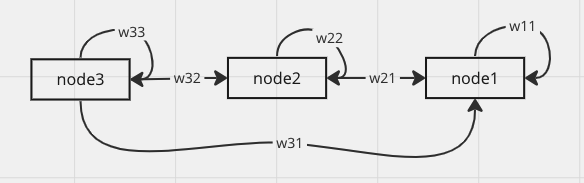

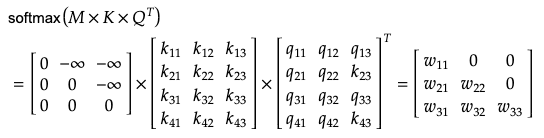

- the directed graph doesnt have positional info, there for we need to add in _positional embedding_ info, without it the attention mechanism doesnt take into account of positioning
  - this is different from convolution network, like images, which contains positional info in the kernel
 
- without the weight mask, the architecture is called an `encoder`.
  - for sentiment anlysis, machine translation, we want all token/nodes to talk to each other, so we dont need the mask
  - with the mask, the current setup, is called a `decoder`, we are learning to predict the next token
  - attention mechanism doesnt care about the mask, it supports arbitarary connection between nodes
 
- **self attention** vs **cross attention**
  - _self attention_: all K,Q,V comes from the same input x, like our case
  - _cross attention_: Q is from input x, K,V comes from another source of input y, like another language.  this is useful for machine translation
 
1 final step is implment the scaling factor $\sqrt{d_k}$ for the following:

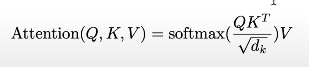

the $\sqrt{d_k}$ is a normalization factor to make sure the product $QK^T$ is normal distribution

In [93]:
# unit guassian attributes k,q
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1)

In [94]:
k.var()

tensor(0.9006)

In [95]:
q.var()

tensor(1.0037)

In [96]:
# the variance is close to head size, no longer unit variance
wei.var()

tensor(15.9317)

In [97]:
# now multiply the scale factor
wei = q @ k.transpose(-2, -1) * head_size**-0.5

# variance is close to 1 again
wei.var()

tensor(0.9957)

In [98]:
# we want variance of wei to be uniform because softmax becomes 1 hot vector when values have extremes
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [99]:
# slightly higher initial value will cause the result to be similar to 1 hot vector
# then anything after we will be just aggregating the highest index value
torch.softmax(torch.tensor([0.1, -0.2, 0.3 -0.2, 0.5])*8, dim=-1)

tensor([0.0376, 0.0034, 0.0376, 0.9215])